### Citation of paper providing original dataset: M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

## **Set up Environment**

In [1]:
#install aimodelshare library
#%% capture
! pip install aimodelshare --upgrade

Requirement already up-to-date: aimodelshare in c:\users\think pad\anaconda3\lib\site-packages (0.0.95)


In [2]:
# Download and unpack data
#%%capture
import zipfile
with zipfile.ZipFile("D:\\COVID-19_Radiography_Database\\COVID-19_Radiography_Database.zip", 'r') as zip_ref:
    zip_ref.extractall("D:\\COVID-19_Radiography_Database")

In [3]:
# Load libraries and then download data
! pip install opencv-python 
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [4]:
# Extracting all filenames iteratively
base_path = "D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database"
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (10).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (100).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1000).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1001).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1002).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1003).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1004).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1005).png', 'D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (1006).png', 'D:\\COVID-19_Radio

## **Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor functions are used to preprocess data into the precise data your model requires to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  


In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
#preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

In [6]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [7]:
len(image_filepaths)

3886

In [8]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
3881      0       0          1
3882      0       0          1
3883      0       0          1
3884      0       0          1
3885      0       0          1

[3886 rows x 3 columns]

## Q1: [10 pts] Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not (You can present visuals of each category in the data if you would like to.).

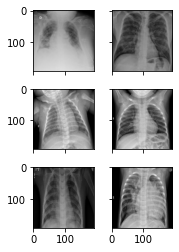

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (100).png')
im2 =preprocessor('D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\COVID\\COVID (200).png')
im3 =preprocessor('D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\NORMAL\\NORMAL (300).png')
im4 =preprocessor('D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\NORMAL\\NORMAL (400).png')
im5 =preprocessor('D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\Viral Pneumonia\\Viral Pneumonia (500).png')
im6 =preprocessor('D:\\COVID-19_Radiography_Database\\COVID-19 Radiography Database\\Viral Pneumonia\\Viral Pneumonia (600).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4,im5,im6]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

## Q2: [10 pts] Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful. Who could benefit from a model like this? Explain.

### There are three types of image in data which are covid, normal and virus pneumonia. We can utilize these tagged images to train the model to better distinguish different symptoms from the others. Application of deep learning can minimize the risk of Flase Negative dignosis and False Positive dignosis by human to prevent the potential spread of varius. Additionally, deep learning model can relief the shortage of doctors (dignosis) and medical resources (quick self-test kit & PCR) with X-rays during the peak of pandemic. In long term, the combination of deep learning model and medical professionals will improve the correctness of dignosis and help medical profesisonals make right decision when it comes to tricky situation.

In [11]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

In [12]:
len(X_train)

3108

In [13]:
len(X_test)

778

In [14]:
len(y_train)

3108

In [15]:
len(y_test)

778

## **Save Preprocessor**
### Saves preprocessor function to "preprocessor.zip" file

In [16]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


## **Submit Models**

In [17]:
#Instantiate Competition 
mycompetition= ai.Competition("https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m")


In [18]:
#Authorized users can submit new models after setting credentials using modelshare.org username/password

apiurl="https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m" # example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m

import aimodelshare
aimodelshare.aws.set_credentials(apiurl=apiurl)

AI Modelshare Username:········
AI Modelshare Password:········
AI Model Share login credentials set successfully.


## Q3: Run at least three prediction models to try to predict x-ray images well. Use transfer learning for at least one of these models

### Model1

In [42]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

98/98 [==============================] - 599s 6s/step - loss: 0.4592 - accuracy: 0.8098 - val_loss: 0.2611 - val_accuracy: 0.9036


### Model1 with one more layer with 16 filters

In [43]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

98/98 [==============================] - 319s 3s/step - loss: 0.4657 - accuracy: 0.7950 - val_loss: 0.2320 - val_accuracy: 0.9139


### Transfer learning based on VGG16 model

In [21]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [22]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [28]:

# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model
  
# summarize
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [41]:

# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
    from tensorflow.python.keras.callbacks import ReduceLROnPlateau
    from tensorflow.python.keras.callbacks import ModelCheckpoint
  
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
    red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

    model.fit(X_train, y_train,batch_size=1,
          epochs = 3, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/3
3108/3108 [==============================] - ETA: 0s - loss: 1.9952 - acc: 0.5843
Epoch 00001: val_acc improved from -inf to 0.57584, saving model to best_model.h5
3108/3108 [==============================] - 978s 310ms/step - loss: 1.9952 - acc: 0.5843 - val_loss: 1.6412 - val_acc: 0.5758 - lr: 0.0100
Epoch 2/3
3108/3108 [==============================] - ETA: 0s - loss: 1.9057 - acc: 0.6065
Epoch 00002: val_acc did not improve from 0.57584
3108/3108 [==============================] - 1002s 322ms/step - loss: 1.9057 - acc: 0.6065 - val_loss: 6.4076 - val_acc: 0.3380 - lr: 0.0100
Epoch 3/3
3108/3108 [==============================] - ETA: 0s - loss: 1.9224 - acc: 0.5927
Epoch 00003: val_acc improved from 0.57584 to 0.59254, saving model to best_model.h5
3108/3108 [==============================] - 1016s 327ms/step - loss: 1.9224 - acc: 0.5927 - val_loss: 2.6942 - val_acc: 0.5925 - lr: 0.0100


In [30]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history
                           .history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01]
2


### Resnet50 Model

In [31]:
# example of loading a version of the Resnet Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

94781440/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [32]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']      

In [36]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input


# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()




Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']       

In [40]:
# Fit Resnet model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

    model.fit(X_train, y_train,
          epochs = 8, verbose=1,validation_data=(X_test,y_test))

Epoch 1/8
98/98 [==============================] - 591s 6s/step - loss: 0.7072 - acc: 0.7680 - val_loss: 0.7007 - val_acc: 0.7699
Epoch 2/8
98/98 [==============================] - 545s 6s/step - loss: 0.7059 - acc: 0.7751 - val_loss: 1.1527 - val_acc: 0.6118
Epoch 3/8
98/98 [==============================] - 530s 5s/step - loss: 0.7001 - acc: 0.7767 - val_loss: 0.6859 - val_acc: 0.7776
Epoch 4/8
98/98 [==============================] - 539s 6s/step - loss: 0.6830 - acc: 0.7822 - val_loss: 1.1538 - val_acc: 0.6337
Epoch 5/8
98/98 [==============================] - 557s 6s/step - loss: 0.6951 - acc: 0.7738 - val_loss: 0.6924 - val_acc: 0.7956
Epoch 6/8
98/98 [==============================] - 601s 6s/step - loss: 0.6862 - acc: 0.7728 - val_loss: 0.6702 - val_acc: 0.7828
Epoch 7/8
98/98 [==============================] - 590s 6s/step - loss: 0.6848 - acc: 0.7745 - val_loss: 0.7154 - val_acc: 0.7789
Epoch 8/8
98/98 [==============================] - 548s 6s/step - loss: 0.6898 - acc: 0.77

### inception_resnet_v2 model from TensorFlow

In [20]:
# example of loading the Inception model

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as Keras


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                

 batch_normalization_10 (BatchN  (None, 21, 21, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 21, 21, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 21, 21, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 21, 21, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 batch_normalization_19 (BatchN  (None, 21, 21, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 21, 21, 48)  144         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_18

                                                                                                  
 block35_3_mixed (Concatenate)  (None, 21, 21, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
                                                                                                  
 block35_3_conv (Conv2D)        (None, 21, 21, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 21, 21, 320)  0           ['block35_2_ac[0][0]',           
                                                                  'block35_3_conv[0][0]']         
                                                                                                  
 block35_3

                                                                                                  
 activation_40 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_38 (Conv2D)             (None, 21, 21, 32)   9216        ['activation_37[0][0]']          
                                                                                                  
 conv2d_41 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_40[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 21, 21, 32)  96          ['conv2d_36[0][0]']              
 ormalizat

 block35_6 (Lambda)             (None, 21, 21, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 21, 21, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_51 (BatchN  (None, 21, 21, 32)  96          ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_59 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 21, 21, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_56 (BatchN  (None, 21, 21, 32)  96          ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_59 (BatchN  (None, 21, 21, 64)  192         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_69 (BatchN  (None, 21, 21, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_70 (Conv2D)             (None, 21, 21, 48)   13824       ['activation_69[0][0]']          
                                                                                                  
 batch_normalization_67 (BatchN  (None, 21, 21, 32)  96          ['conv2d_67[0][0]']              
 ormalizat

                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 10, 10, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 10, 10, 128)  384        ['conv2d_77[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_77[0][0]']          
          

                                                                                                  
 batch_normalization_85 (BatchN  (None, 10, 10, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_86 (BatchN  (None, 10, 10, 160)  480        ['conv2d_86[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_93 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_93[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 10, 10, 160)  480        ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 10, 10, 160)  0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_92

 conv2d_102 (Conv2D)            (None, 10, 10, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 10, 10, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_102 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_102[0][0]']
                                                                                                  
 conv2d_100 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_6_ac[0][0]']           
                                                                                                  
 conv2d_103 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_102[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_108 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_8_ac[0][0]']           
                                                                                                  
 conv2d_111 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_110[0][0]']         
                                                                                                  
 batch_normalization_108 (Batch  (None, 10, 10, 192)  576        ['conv2d_108[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_116 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_118[0][0]']         
                                                                                                  
 batch_normalization_116 (Batch  (None, 10, 10, 192)  576        ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_119 (Batch  (None, 10, 10, 192)  576        ['conv2d_119[0][0]']             
 Normalization)                                                                                   
          

 conv2d_127 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 10, 10, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_127 (Batch  (None, 10, 10, 192)  576        ['conv2d_127[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_124 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_124[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 10, 10, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_132 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_132[0][0]']
                                                                                                  
 activation_135 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_135[0][0]']
                                                                                                  
 block17_15_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_132[0][0]',         
          

 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activation_143 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_143[0][0]']
                                                                                                  
 block17_17_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_140[0][0]',         
                                                                  'activation_143[0][0]']         
                                                                                                  
 block17_17_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_17_mixed[0][0]']       
          

                                                                                                  
 activation_151 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_148[0][0]',         
                                                                  'activation_151[0][0]']         
                                                                                                  
 block17_19_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_19_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_19 (Lambda)            (None, 10, 10, 1088  0           ['block17_18_ac[0][0]',          
          

 conv2d_157 (Conv2D)            (None, 4, 4, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 4, 4, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_162 (Conv2D)            (None, 4, 4, 320)    829440      ['activation_161[0][0]']         
                                                                                                  
 batch_normalization_157 (Batch  (None, 4, 4, 384)   1152        ['conv2d_157[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_159 (Batch  (None, 4, 4, 288)   864         ['conv2d_159[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_167 (Batch  (None, 4, 4, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_170 (Batch  (None, 4, 4, 256)   768         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_167 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_167[0][0]']
                                                                                                  
 activation_170 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_170[0][0]']
          

 activation_175 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_mixed (Concatenate)   (None, 4, 4, 448)    0           ['activation_175[0][0]',         
                                                                  'activation_178[0][0]']         
                                                                                                  
 block8_4_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_4_mixed[0][0]']         
                                                                                                  
 block8_4 (Lambda)              (None, 4, 4, 2080)   0           ['block8_3_ac[0][0]',            
          

 block8_6_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 4, 4, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
                                                                                                  
 block8_6_ac (Activation)       (None, 4, 4, 2080)   0           ['block8_6[0][0]']               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_6_ac[0][0]']            
                                                                                                  
 batch_normalization_188 (Batch  (None, 4, 4, 192)   576         ['conv2d_188[0][0]']             
 Normaliza

 conv2d_196 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 4, 4, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_196 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_196[0][0]']
                                                                                                  
 conv2d_197 (Conv2D)            (None, 4, 4, 224)    129024      ['activation_196[0][0]']         
                                                                                                  
 batch_normalization_197 (Batch  (None, 4, 4, 224)   672         ['conv2d_197[0][0]']             
 Normaliza

__________________________________________________________________________________________________


In [21]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                

 batch_normalization_10 (BatchN  (None, 21, 21, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 21, 21, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 21, 21, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 21, 21, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 batch_normalization_19 (BatchN  (None, 21, 21, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 21, 21, 48)  144         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_18

                                                                                                  
 block35_3_mixed (Concatenate)  (None, 21, 21, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
                                                                                                  
 block35_3_conv (Conv2D)        (None, 21, 21, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 21, 21, 320)  0           ['block35_2_ac[0][0]',           
                                                                  'block35_3_conv[0][0]']         
                                                                                                  
 block35_3

                                                                                                  
 activation_40 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_38 (Conv2D)             (None, 21, 21, 32)   9216        ['activation_37[0][0]']          
                                                                                                  
 conv2d_41 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_40[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 21, 21, 32)  96          ['conv2d_36[0][0]']              
 ormalizat

 block35_6 (Lambda)             (None, 21, 21, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 21, 21, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_51 (BatchN  (None, 21, 21, 32)  96          ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_59 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 21, 21, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_56 (BatchN  (None, 21, 21, 32)  96          ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_59 (BatchN  (None, 21, 21, 64)  192         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_69 (BatchN  (None, 21, 21, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_70 (Conv2D)             (None, 21, 21, 48)   13824       ['activation_69[0][0]']          
                                                                                                  
 batch_normalization_67 (BatchN  (None, 21, 21, 32)  96          ['conv2d_67[0][0]']              
 ormalizat

                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 10, 10, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 10, 10, 128)  384        ['conv2d_77[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_77[0][0]']          
          

                                                                                                  
 batch_normalization_85 (BatchN  (None, 10, 10, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_86 (BatchN  (None, 10, 10, 160)  480        ['conv2d_86[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_93 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_93[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 10, 10, 160)  480        ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 10, 10, 160)  0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_92

 conv2d_102 (Conv2D)            (None, 10, 10, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 10, 10, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_102 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_102[0][0]']
                                                                                                  
 conv2d_100 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_6_ac[0][0]']           
                                                                                                  
 conv2d_103 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_102[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_108 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_8_ac[0][0]']           
                                                                                                  
 conv2d_111 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_110[0][0]']         
                                                                                                  
 batch_normalization_108 (Batch  (None, 10, 10, 192)  576        ['conv2d_108[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_116 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_118[0][0]']         
                                                                                                  
 batch_normalization_116 (Batch  (None, 10, 10, 192)  576        ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_119 (Batch  (None, 10, 10, 192)  576        ['conv2d_119[0][0]']             
 Normalization)                                                                                   
          

 conv2d_127 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 10, 10, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_127 (Batch  (None, 10, 10, 192)  576        ['conv2d_127[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_124 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_124[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 10, 10, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_132 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_132[0][0]']
                                                                                                  
 activation_135 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_135[0][0]']
                                                                                                  
 block17_15_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_132[0][0]',         
          

 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activation_143 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_143[0][0]']
                                                                                                  
 block17_17_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_140[0][0]',         
                                                                  'activation_143[0][0]']         
                                                                                                  
 block17_17_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_17_mixed[0][0]']       
          

                                                                                                  
 activation_151 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_148[0][0]',         
                                                                  'activation_151[0][0]']         
                                                                                                  
 block17_19_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_19_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_19 (Lambda)            (None, 10, 10, 1088  0           ['block17_18_ac[0][0]',          
          

 conv2d_157 (Conv2D)            (None, 4, 4, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 4, 4, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_162 (Conv2D)            (None, 4, 4, 320)    829440      ['activation_161[0][0]']         
                                                                                                  
 batch_normalization_157 (Batch  (None, 4, 4, 384)   1152        ['conv2d_157[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_159 (Batch  (None, 4, 4, 288)   864         ['conv2d_159[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_167 (Batch  (None, 4, 4, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_170 (Batch  (None, 4, 4, 256)   768         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_167 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_167[0][0]']
                                                                                                  
 activation_170 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_170[0][0]']
          

 activation_175 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_mixed (Concatenate)   (None, 4, 4, 448)    0           ['activation_175[0][0]',         
                                                                  'activation_178[0][0]']         
                                                                                                  
 block8_4_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_4_mixed[0][0]']         
                                                                                                  
 block8_4 (Lambda)              (None, 4, 4, 2080)   0           ['block8_3_ac[0][0]',            
          

 block8_6_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 4, 4, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
                                                                                                  
 block8_6_ac (Activation)       (None, 4, 4, 2080)   0           ['block8_6[0][0]']               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_6_ac[0][0]']            
                                                                                                  
 batch_normalization_188 (Batch  (None, 4, 4, 192)   576         ['conv2d_188[0][0]']             
 Normaliza

 conv2d_196 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 4, 4, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_196 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_196[0][0]']
                                                                                                  
 conv2d_197 (Conv2D)            (None, 4, 4, 224)    129024      ['activation_196[0][0]']         
                                                                                                  
 batch_normalization_197 (Batch  (None, 4, 4, 224)   672         ['conv2d_197[0][0]']             
 Normaliza

__________________________________________________________________________________________________


In [22]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 21, 21, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 21, 21, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 21, 21, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 21, 21, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 batch_normalization_19 (BatchN  (None, 21, 21, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 21, 21, 48)  144         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_18

                                                                                                  
 block35_3_mixed (Concatenate)  (None, 21, 21, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
                                                                                                  
 block35_3_conv (Conv2D)        (None, 21, 21, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 21, 21, 320)  0           ['block35_2_ac[0][0]',           
                                                                  'block35_3_conv[0][0]']         
                                                                                                  
 block35_3

                                                                                                  
 activation_40 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_38 (Conv2D)             (None, 21, 21, 32)   9216        ['activation_37[0][0]']          
                                                                                                  
 conv2d_41 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_40[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 21, 21, 32)  96          ['conv2d_36[0][0]']              
 ormalizat

 block35_6 (Lambda)             (None, 21, 21, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 21, 21, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_51 (BatchN  (None, 21, 21, 32)  96          ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_59 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 21, 21, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_56 (BatchN  (None, 21, 21, 32)  96          ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_59 (BatchN  (None, 21, 21, 64)  192         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_69 (BatchN  (None, 21, 21, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_70 (Conv2D)             (None, 21, 21, 48)   13824       ['activation_69[0][0]']          
                                                                                                  
 batch_normalization_67 (BatchN  (None, 21, 21, 32)  96          ['conv2d_67[0][0]']              
 ormalizat

                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 10, 10, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 10, 10, 128)  384        ['conv2d_77[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_77[0][0]']          
          

                                                                                                  
 batch_normalization_85 (BatchN  (None, 10, 10, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_86 (BatchN  (None, 10, 10, 160)  480        ['conv2d_86[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_93 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_93[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 10, 10, 160)  480        ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 10, 10, 160)  0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_92

 conv2d_102 (Conv2D)            (None, 10, 10, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 10, 10, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_102 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_102[0][0]']
                                                                                                  
 conv2d_100 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_6_ac[0][0]']           
                                                                                                  
 conv2d_103 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_102[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_108 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_8_ac[0][0]']           
                                                                                                  
 conv2d_111 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_110[0][0]']         
                                                                                                  
 batch_normalization_108 (Batch  (None, 10, 10, 192)  576        ['conv2d_108[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_116 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_118[0][0]']         
                                                                                                  
 batch_normalization_116 (Batch  (None, 10, 10, 192)  576        ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_119 (Batch  (None, 10, 10, 192)  576        ['conv2d_119[0][0]']             
 Normalization)                                                                                   
          

 conv2d_127 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 10, 10, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_127 (Batch  (None, 10, 10, 192)  576        ['conv2d_127[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_124 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_124[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 10, 10, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_132 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_132[0][0]']
                                                                                                  
 activation_135 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_135[0][0]']
                                                                                                  
 block17_15_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_132[0][0]',         
          

 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activation_143 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_143[0][0]']
                                                                                                  
 block17_17_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_140[0][0]',         
                                                                  'activation_143[0][0]']         
                                                                                                  
 block17_17_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_17_mixed[0][0]']       
          

                                                                                                  
 activation_151 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_148[0][0]',         
                                                                  'activation_151[0][0]']         
                                                                                                  
 block17_19_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_19_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_19 (Lambda)            (None, 10, 10, 1088  0           ['block17_18_ac[0][0]',          
          

 conv2d_157 (Conv2D)            (None, 4, 4, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 4, 4, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_162 (Conv2D)            (None, 4, 4, 320)    829440      ['activation_161[0][0]']         
                                                                                                  
 batch_normalization_157 (Batch  (None, 4, 4, 384)   1152        ['conv2d_157[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_159 (Batch  (None, 4, 4, 288)   864         ['conv2d_159[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_167 (Batch  (None, 4, 4, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_170 (Batch  (None, 4, 4, 256)   768         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_167 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_167[0][0]']
                                                                                                  
 activation_170 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_170[0][0]']
          

 activation_175 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_mixed (Concatenate)   (None, 4, 4, 448)    0           ['activation_175[0][0]',         
                                                                  'activation_178[0][0]']         
                                                                                                  
 block8_4_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_4_mixed[0][0]']         
                                                                                                  
 block8_4 (Lambda)              (None, 4, 4, 2080)   0           ['block8_3_ac[0][0]',            
          

 block8_6_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 4, 4, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
                                                                                                  
 block8_6_ac (Activation)       (None, 4, 4, 2080)   0           ['block8_6[0][0]']               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_6_ac[0][0]']            
                                                                                                  
 batch_normalization_188 (Batch  (None, 4, 4, 192)   576         ['conv2d_188[0][0]']             
 Normaliza

 conv2d_196 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 4, 4, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_196 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_196[0][0]']
                                                                                                  
 conv2d_197 (Conv2D)            (None, 4, 4, 224)    129024      ['activation_196[0][0]']         
                                                                                                  
 batch_normalization_197 (Batch  (None, 4, 4, 224)   672         ['conv2d_197[0][0]']             
 Normaliza

                                                                                                  
 dense (Dense)                  (None, 3)            4611        ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
Total params: 54,341,347
Trainable params: 4,611
Non-trainable params: 54,336,736
__________________________________________________________________________________________________


In [69]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
98/98 [==============================] - 515s 5s/step - loss: 0.4091 - acc: 0.8311 - val_loss: 0.2215 - val_acc: 0.9254
Epoch 2/5
98/98 [==============================] - 419s 4s/step - loss: 0.2339 - acc: 0.9173 - val_loss: 0.1884 - val_acc: 0.9344
Epoch 3/5
98/98 [==============================] - 392s 4s/step - loss: 0.1953 - acc: 0.9324 - val_loss: 0.1688 - val_acc: 0.9434
Epoch 4/5
98/98 [==============================] - 393s 4s/step - loss: 0.1750 - acc: 0.9376 - val_loss: 0.1666 - val_acc: 0.9434
Epoch 5/5
98/98 [==============================] - 428s 4s/step - loss: 0.1644 - acc: 0.9411 - val_loss: 0.1554 - val_acc: 0.9499


In [34]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 8, verbose=1,validation_data=(X_test,y_test))

Epoch 1/8
98/98 [==============================] - 526s 5s/step - loss: 0.1276 - acc: 0.9537 - val_loss: 0.1342 - val_acc: 0.9537
Epoch 2/8
98/98 [==============================] - 466s 5s/step - loss: 0.1032 - acc: 0.9646 - val_loss: 0.1395 - val_acc: 0.9473
Epoch 3/8
98/98 [==============================] - 459s 5s/step - loss: 0.1188 - acc: 0.9537 - val_loss: 0.1332 - val_acc: 0.9499
Epoch 4/8
98/98 [==============================] - 447s 5s/step - loss: 0.1008 - acc: 0.9636 - val_loss: 0.1361 - val_acc: 0.9537
Epoch 5/8
98/98 [==============================] - 435s 4s/step - loss: 0.0965 - acc: 0.9643 - val_loss: 0.1510 - val_acc: 0.9447
Epoch 6/8
98/98 [==============================] - 462s 5s/step - loss: 0.0899 - acc: 0.9707 - val_loss: 0.1795 - val_acc: 0.9473
Epoch 7/8
98/98 [==============================] - 448s 5s/step - loss: 0.1026 - acc: 0.9656 - val_loss: 0.1485 - val_acc: 0.9460
Epoch 8/8
98/98 [==============================] - 463s 5s/step - loss: 0.0930 - acc: 0.96

In [23]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 12, verbose=1,validation_data=(X_test,y_test))

Epoch 1/12
98/98 [==============================] - 512s 5s/step - loss: 0.4943 - acc: 0.8079 - val_loss: 0.2407 - val_acc: 0.9165
Epoch 2/12
98/98 [==============================] - 529s 5s/step - loss: 0.2396 - acc: 0.9147 - val_loss: 0.1968 - val_acc: 0.9293
Epoch 3/12
98/98 [==============================] - 456s 5s/step - loss: 0.1971 - acc: 0.9302 - val_loss: 0.1755 - val_acc: 0.9396
Epoch 4/12
98/98 [==============================] - 450s 5s/step - loss: 0.1786 - acc: 0.9385 - val_loss: 0.1625 - val_acc: 0.9460
Epoch 5/12
98/98 [==============================] - 445s 5s/step - loss: 0.1613 - acc: 0.9450 - val_loss: 0.1540 - val_acc: 0.9473
Epoch 6/12
98/98 [==============================] - 437s 4s/step - loss: 0.1697 - acc: 0.9414 - val_loss: 0.1618 - val_acc: 0.9409
Epoch 7/12
98/98 [==============================] - 441s 5s/step - loss: 0.1438 - acc: 0.9492 - val_loss: 0.1534 - val_acc: 0.9512
Epoch 8/12
98/98 [==============================] - 441s 5s/step - loss: 0.1443 - a

In [24]:
import tensorflow.keras.backend as K

print(K.eval(model.optimizer.get_config()))

print(model.get_config())

print(len(model.history.epoch))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'name': 'input_1', 'inbound_nodes': []}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'conv2d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'class_name': 'BatchNormal

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.588943 to fit



In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 21, 21, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 21, 21, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 21, 21, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 21, 21, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 batch_normalization_19 (BatchN  (None, 21, 21, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 21, 21, 48)  144         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_18

                                                                                                  
 block35_3_mixed (Concatenate)  (None, 21, 21, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
                                                                                                  
 block35_3_conv (Conv2D)        (None, 21, 21, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 21, 21, 320)  0           ['block35_2_ac[0][0]',           
                                                                  'block35_3_conv[0][0]']         
                                                                                                  
 block35_3

                                                                                                  
 activation_40 (Activation)     (None, 21, 21, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_38 (Conv2D)             (None, 21, 21, 32)   9216        ['activation_37[0][0]']          
                                                                                                  
 conv2d_41 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_40[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 21, 21, 32)  96          ['conv2d_36[0][0]']              
 ormalizat

 block35_6 (Lambda)             (None, 21, 21, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 21, 21, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_51 (BatchN  (None, 21, 21, 32)  96          ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_59 (Conv2D)             (None, 21, 21, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 21, 21, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_56 (BatchN  (None, 21, 21, 32)  96          ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_59 (BatchN  (None, 21, 21, 64)  192         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_69 (BatchN  (None, 21, 21, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 21, 21, 32)   0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 21, 21, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_70 (Conv2D)             (None, 21, 21, 48)   13824       ['activation_69[0][0]']          
                                                                                                  
 batch_normalization_67 (BatchN  (None, 21, 21, 32)  96          ['conv2d_67[0][0]']              
 ormalizat

                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 10, 10, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 10, 10, 128)  384        ['conv2d_77[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_77[0][0]']          
          

                                                                                                  
 batch_normalization_85 (BatchN  (None, 10, 10, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_86 (BatchN  (None, 10, 10, 160)  480        ['conv2d_86[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_93 (Activation)     (None, 10, 10, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 10, 10, 160)  143360      ['activation_93[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 10, 10, 160)  480        ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 10, 10, 160)  0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_92

 conv2d_102 (Conv2D)            (None, 10, 10, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 10, 10, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_102 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_102[0][0]']
                                                                                                  
 conv2d_100 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_6_ac[0][0]']           
                                                                                                  
 conv2d_103 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_102[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 10, 10, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_108 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_8_ac[0][0]']           
                                                                                                  
 conv2d_111 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_110[0][0]']         
                                                                                                  
 batch_normalization_108 (Batch  (None, 10, 10, 192)  576        ['conv2d_108[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_116 (Conv2D)            (None, 10, 10, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_118[0][0]']         
                                                                                                  
 batch_normalization_116 (Batch  (None, 10, 10, 192)  576        ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_119 (Batch  (None, 10, 10, 192)  576        ['conv2d_119[0][0]']             
 Normalization)                                                                                   
          

 conv2d_127 (Conv2D)            (None, 10, 10, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 10, 10, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_127 (Batch  (None, 10, 10, 192)  576        ['conv2d_127[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_124 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_124[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 10, 10, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_132 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_132[0][0]']
                                                                                                  
 activation_135 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_135[0][0]']
                                                                                                  
 block17_15_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_132[0][0]',         
          

 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activation_143 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_143[0][0]']
                                                                                                  
 block17_17_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_140[0][0]',         
                                                                  'activation_143[0][0]']         
                                                                                                  
 block17_17_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_17_mixed[0][0]']       
          

                                                                                                  
 activation_151 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 10, 10, 384)  0          ['activation_148[0][0]',         
                                                                  'activation_151[0][0]']         
                                                                                                  
 block17_19_conv (Conv2D)       (None, 10, 10, 1088  418880      ['block17_19_mixed[0][0]']       
                                )                                                                 
                                                                                                  
 block17_19 (Lambda)            (None, 10, 10, 1088  0           ['block17_18_ac[0][0]',          
          

 conv2d_157 (Conv2D)            (None, 4, 4, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 4, 4, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_162 (Conv2D)            (None, 4, 4, 320)    829440      ['activation_161[0][0]']         
                                                                                                  
 batch_normalization_157 (Batch  (None, 4, 4, 384)   1152        ['conv2d_157[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_159 (Batch  (None, 4, 4, 288)   864         ['conv2d_159[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_167 (Batch  (None, 4, 4, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_170 (Batch  (None, 4, 4, 256)   768         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_167 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_167[0][0]']
                                                                                                  
 activation_170 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_170[0][0]']
          

 activation_175 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_mixed (Concatenate)   (None, 4, 4, 448)    0           ['activation_175[0][0]',         
                                                                  'activation_178[0][0]']         
                                                                                                  
 block8_4_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_4_mixed[0][0]']         
                                                                                                  
 block8_4 (Lambda)              (None, 4, 4, 2080)   0           ['block8_3_ac[0][0]',            
          

 block8_6_conv (Conv2D)         (None, 4, 4, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 4, 4, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
                                                                                                  
 block8_6_ac (Activation)       (None, 4, 4, 2080)   0           ['block8_6[0][0]']               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_6_ac[0][0]']            
                                                                                                  
 batch_normalization_188 (Batch  (None, 4, 4, 192)   576         ['conv2d_188[0][0]']             
 Normaliza

 conv2d_196 (Conv2D)            (None, 4, 4, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 4, 4, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_196 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_196[0][0]']
                                                                                                  
 conv2d_197 (Conv2D)            (None, 4, 4, 224)    129024      ['activation_196[0][0]']         
                                                                                                  
 batch_normalization_197 (Batch  (None, 4, 4, 224)   672         ['conv2d_197[0][0]']             
 Normaliza

                                                                                                  
 dense (Dense)                  (None, 3)            4611        ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
Total params: 54,341,347
Trainable params: 4,611
Non-trainable params: 54,336,736
__________________________________________________________________________________________________


In [27]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model_best = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model_best.SerializeToString())

In [28]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[2 1 0 1 2 0 1 0 1 1 1 2 0 2 0 2 0 1 1 1 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 1 0 1 0 0 1 2 1 0 1 2 0 0
 0 0 2 2 2 0 2 1 2 1 2 1 1 0 2 0 1 0 1 1 2 1 0 0 0 0 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 2 1 1 2 0 0 0 2 0 2 1 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 0 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 2 2 0 1 1 1 1 1 0 1 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 2 2 2 1 2 2 0 1 0 2 2 0 0 0 1 0 2 1 1 0 2 2 2
 2 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 1 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 1 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 1 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 1 0 1 0 2 0 1 2 0 1 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [29]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 151

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1539


Get Leaderboard

In [30]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

### [10 pts] Discuss which models performed better and point out relevant hyper-parameter values for successful models.

### Batching Normalization: The batching normalization between fully connected layer and activation function layer is extremelly important for a higher accuracy model, since the output from Tanh activation layer will not sensitive to the bigger value input even when the input value is extremlly high. 
### Activation function Layer: Based on the problem mentioned in Batching Normalization, adpoting Relu activation function may solve the Problem and also eliminate the problem of gradient vanishing. Additionally, Relu activation function run much faster and have a higher rate of convergence than the other activation function such as sig and tanh.
### Epochs: Based on the test results, the more epochs, the higher accuracy is. 
### Number of Layers: Adding more layers may contribute to a higher accuracy sometimes.

### [20 pts] Import the best model from the leader board (whatever the best model is after your final submission) Note: Use the aimodelshare instantiate_model() function
### 1) Visualize the model's structure using tf.keras model.summary()

In [40]:
so_called_best_model = mycompetition.instantiate_model(45)
so_called_best_model.summary()

Instantiate the model from metadata..
Your model is successfully instantiated.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      4128      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        8256      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48

### 2) Explain how the model's structure is different from your best model.
### There are 13 layers in the so_call_best_model model, including one flatten layer and two fully connected layers
### The general struture of my best model-inception_resnet_v2 model is the transfering model based on VGG16 model. Noticeably, there are some parallel processing layers after max pooling layer and finally concatenate after some convolution layer and activation. Take max_pooling2d_1 after activation_4 for example, we can see that there are four parallel processing layer after max pooling. Averaging pooling is the only pooling layers being added afterwards, whereas the other three layers are convolution layers. From my perspective, it is very likely that average pooling layer is for better extract the feature and lossing some unnecessary information enable calculation much faster. This parallel processing is repeated 43 times, which means there are 43 grid module in this model. Additionally, Residual Connections module and larger network scale in inception_resnet_v2 model accelerate newtwork convergence and improve the newtwork accuracy. 
### 3) Explain how the model's optimization approach is different from your best model
### The so-called-best model adopting two convolution layers every single time before max pooling to make output much deeper and extract the feature in a better manner. Besides, one flatten layer is applied to favor the classification in the fully connnected layers.
### My best model utilizes batching normalization between the convolution layer and activation layer to eliminate the gradient vanishing problem. Additionally, multiple paralle convolution layers are adpoted after each pooling to better extract the features from the image. Lastly, my best model have residual connections module and larger network scale, which will contribute to a faster network convergence and a higher accuracy.

In [42]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  so_called_best_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  so_called_best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

so_called_best_model.fit(X_train, y_train,
          epochs = 4, verbose=1,validation_data=(X_test,y_test))

Epoch 1/4
98/98 [==============================] - 302s 3s/step - loss: 0.4462 - acc: 0.8218 - val_loss: 0.2230 - val_acc: 0.9254
Epoch 2/4
98/98 [==============================] - 293s 3s/step - loss: 0.1911 - acc: 0.9289 - val_loss: 0.2142 - val_acc: 0.9344
Epoch 3/4
98/98 [==============================] - 272s 3s/step - loss: 0.1406 - acc: 0.9521 - val_loss: 0.1296 - val_acc: 0.9537
Epoch 4/4
98/98 [==============================] - 264s 3s/step - loss: 0.0943 - acc: 0.9640 - val_loss: 0.1417 - val_acc: 0.9614
